In [14]:
import pandas as pd
import numpy as np
import jax
from IPython.display import Markdown, display
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
import numpyro
from jax import random
import numpyro.distributions as dist
from functions import plot_z
import warnings
warnings.simplefilter('ignore')
import seaborn as sns
import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from numpyro.contrib.control_flow import scan
from tqdm import tqdm
import arviz as az
import matplotlib.pyplot as plt
from IPython.display import display, Math
import warnings
warnings.simplefilter('ignore')

class ProgressBar:
    def __init__(self, total):
        self.pbar = tqdm(total=total, desc="Sampling Progress", position=0, leave=True)

    def update(self, value):
        self.pbar.update(value)

    def close(self):
        self.pbar.close()

---
## Real data
### Period 
1983-2018 Q
### Output gap
Beveridge-Nelson Filter (https://bnfiltering.com)

### Inflation Expectation
Fed of Cleveland (https://www.clevelandfed.org/indicators-and-data/inflation-expectations)

one year inflation expectation
### Inflation rate
FRED (https://fred.stlouisfed.org/series/CPIAUCSL)

Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 

---

In [2]:
data_cpi = pd.read_csv("data/CPIAUCSL.csv", parse_dates=["DATE"])
data_cpi.set_index("DATE", inplace=True)
data_cpi = data_cpi.resample("QS").mean()
data_cpi['pi'] = data_cpi['CPIAUCSL'].pct_change() * 100
data_cpi = data_cpi['pi']
data_cpi = data_cpi.reset_index()

data_gap = pd.read_csv("data/BN_filter_GDPC1_quaterly.csv")
data_gap['Y'] = data_gap["cycle"]
data_gap['DATE'] = data_gap["date"]
data_gap = data_gap[["DATE", "Y"]]

data_Epi = pd.read_csv("data/one_year_inflation_expectation.csv")
data_Epi['DATE'] = pd.to_datetime(data_Epi['Model Output Date'])
data_Epi.set_index("DATE", inplace=True)
data_Epi = data_Epi[[" 1 year Expected Inflation"]].resample("QS").mean() * 100 / 4
data_Epi['Epi'] = data_Epi[' 1 year Expected Inflation']
data_Epi = data_Epi.reset_index()
data_Epi = data_Epi[["DATE", "Epi"]]

data_cpi['DATE'] = pd.to_datetime(data_cpi['DATE'])
data_gap['DATE'] = pd.to_datetime(data_gap['DATE'])
data_Epi['DATE'] = pd.to_datetime(data_Epi['DATE'])


data = pd.merge(data_cpi, data_Epi, on="DATE", how="outer")
data = pd.merge(data, data_gap, on="DATE", how="outer")
data["pi_prev"] = data["pi"].shift(1)
data["Y_prev"] = data["Y"].shift(1)
data.dropna(inplace=True)
# data = data[data['DATE'] < '2008-07-01']

# for MCMC
pi = jnp.array(data['pi'])
pi_prev = jnp.array(data['pi_prev'])
pi_expect = jnp.array(data['Epi'])
Y = jnp.array(data['Y'])
Y_prev = jnp.array(data['Y_prev'])

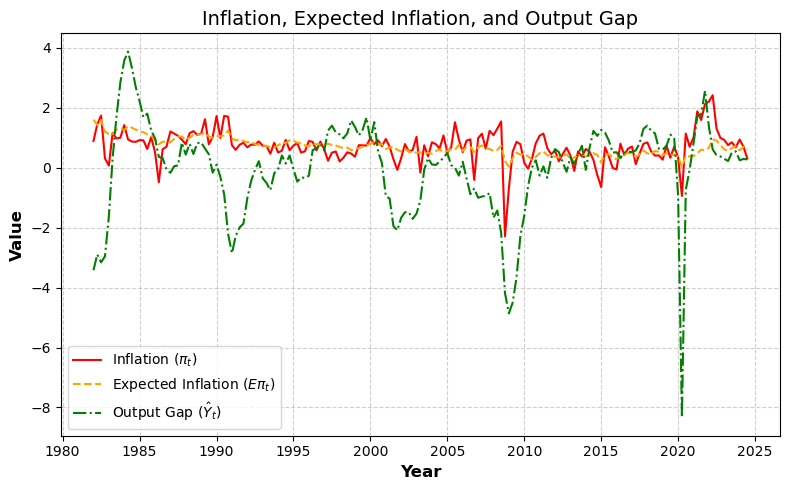

In [3]:
# data
plt.figure(figsize=(8, 5))
plt.plot(data["DATE"], data["pi"], label=r'Inflation $(\pi_{t})$', linestyle='-', color='red')       
plt.plot(data["DATE"], data["Epi"], label=r'Expected Inflation $(E\pi_{t})$', linestyle='--', color='orange')    
plt.plot(data["DATE"], data["Y"], label='Output Gap $(\hat{Y}_{t})$', linestyle='-.', color='green') 
plt.xlabel('Year', fontsize=12, weight='bold')
plt.ylabel('Value', fontsize=12, weight='bold')
plt.title('Inflation, Expected Inflation, and Output Gap', fontsize=14)
plt.legend(fontsize=10, frameon=True, loc='lower left', fancybox=True)
plt.grid(visible=True, linestyle='--', alpha=0.6)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

####  Model

"COMPETITION AND THE PHILLIPS CURVE"

Ippei Fujiwara and Kiminori Matsuyama

NKPC in terms of the output gap is given by:

$$
\hat{\pi}_t 
= \beta E_t[\hat{\pi}_{t+1}]
  \;+\;\kappa(z)\,\hat{Y}_t
  \;-\;\frac{\zeta(z) - 1}{\chi}\,\frac{1 - \rho(z)}{\rho(z)}\,\hat{z}_t,
$$

where

$$
\kappa(z)
:= \frac{\zeta(z) - 1}{\chi}
   \,\frac{1}{1 + \psi}
   \,\frac{
       (\sigma + \psi)
       \;-\;\bigl(1 - \sigma\bigr)\,\dfrac{1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }{
       1
       \;-\;\dfrac{\zeta(z) - 1}{s(z)}
            \displaystyle\int_{z}^{\bar{z}}
              \dfrac{s(\tilde{z})}{\tilde{z}}\,d\tilde{z}
   }.
$$

## Estimation

The observed variable $\pi_t$ is the inflation rate, $\text{E}\pi_t$ is the expected inflation rate, and $\text{gap}_t$ is the output gap


In [42]:
warmup= 100000
samples=100000
chains = 2
rng_key = jax.random.PRNGKey(0)

In [43]:
#--------------------------------------------------------------------------------
def set_prior_distributions():
    priors = {
        "beta" : dist.Gamma(concentration=2, rate=10),
        "kappa": dist.Gamma(concentration=2, rate=10),
        "theta": dist.Gamma(concentration=2, rate=10),
        "gamma": dist.Gamma(concentration=2, rate=10),
        "rho"  : dist.TruncatedNormal(-0.5, 0.2, high=0),
        "delta": dist.Gamma(concentration=2, rate=10),
        "sigma_eps": dist.HalfCauchy(scale=1),
        "sigma_eta": dist.HalfCauchy(scale=1)
    }
    return priors

# Y_{t-1}

def model_4(pi, pi_prev , pi_expect, Y, Y_prev, l):
    priors = set_prior_distributions()
    beta = numpyro.sample("beta", priors["beta"])
    alpha = 1 - beta
    numpyro.deterministic("alpha",alpha)
    kappa = numpyro.sample("kappa", priors["kappa"])
    # theta = numpyro.sample("theta", priors["theta"])
    rho = numpyro.sample("rho", priors["rho"])

    # error terms
    sigma_eps = numpyro.sample("sigma_eps", priors["sigma_eps"])
    sigma_eta = numpyro.sample("sigma_eta", priors["sigma_eta"])
    
    # initial z
    z_init = 1
    
    # state space model
    timesteps = jnp.arange(l)
    t = 0
    def transition(carry, _):
        z_prev = carry[0]
        t = carry[1]
        z = numpyro.sample("z", numpyro.distributions.Normal(rho * Y_prev[t], sigma_eta))
        z_carry = z
        pi_pred = alpha * pi_prev[t] + beta * pi_expect[t] + kappa * Y[t] - z
        numpyro.sample(f"pi_obs", numpyro.distributions.Normal(pi_pred, sigma_eps), obs=pi[t])
        t_carry = t + 1
        return [z_carry, t_carry], None
    scan(transition, [z_init, t], timesteps)

In [44]:
# RUN MCMC
kernel = NUTS(model_4)
mcmc = MCMC(kernel, num_warmup=warmup, num_samples=samples, num_chains=chains)
mcmc.run(rng_key, pi=pi, pi_prev = pi_prev, Y_prev = Y_prev, pi_expect=pi_expect, Y=Y, l=len(pi))
idata_1 = az.from_numpyro(mcmc)
# Results
posterior_samples = mcmc.get_samples()
z_samples = posterior_samples["z"]
z_mean_1 = np.mean(z_samples, axis=0) 
z_std = np.std(z_samples, axis=0)  
z_lower_1 = z_mean_1 - 1.96 * z_std     
z_upper_1 = z_mean_1 + 1.96 * z_std  

sample: 100%|██████████| 200000/200000 [01:39<00:00, 2013.74it/s, 63 steps of size 6.08e-02. acc. prob=0.89] 


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'kappa'}>,
        <Axes: title={'center': 'kappa'}>],
       [<Axes: title={'center': 'rho'}>, <Axes: title={'center': 'rho'}>],
       [<Axes: title={'center': 'sigma_eps'}>,
        <Axes: title={'center': 'sigma_eps'}>],
       [<Axes: title={'center': 'sigma_eta'}>,
        <Axes: title={'center': 'sigma_eta'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

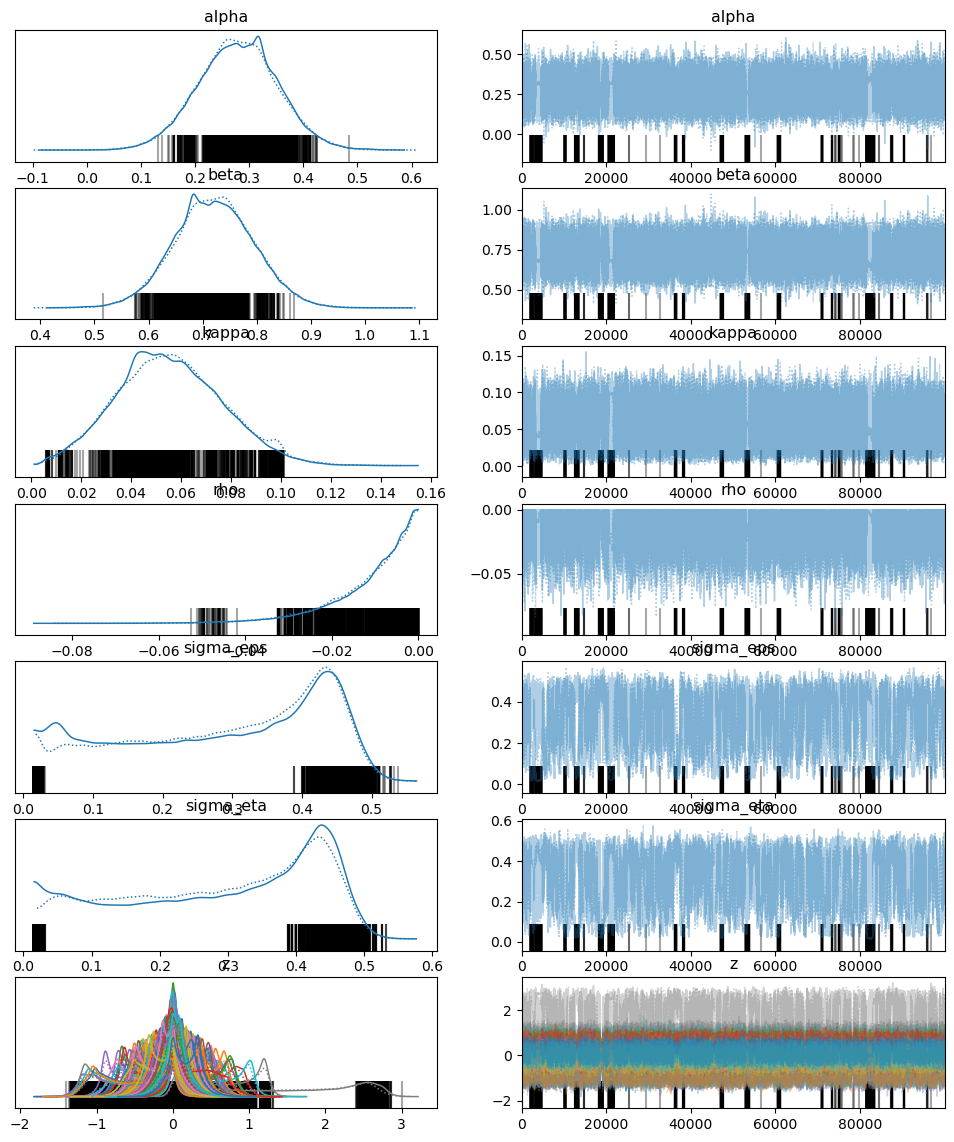

In [45]:
az.plot_trace(idata_1)

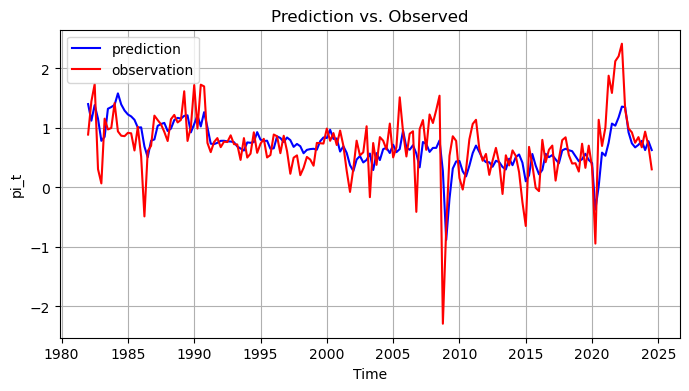

Bayesian R^2: 0.3728024959564209


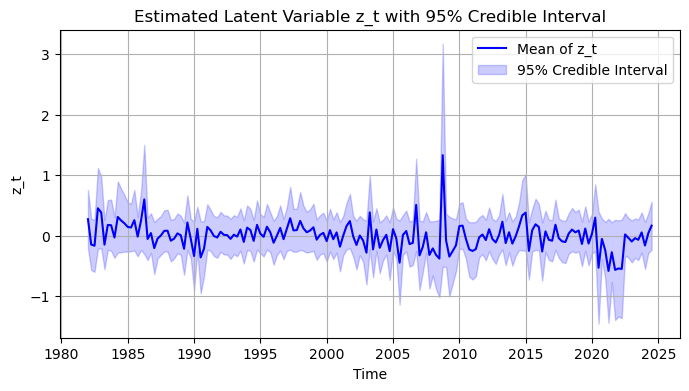

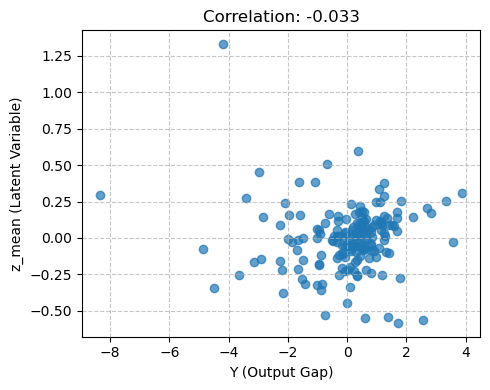

In [46]:
import numpy as np
import matplotlib.pyplot as plt

model_number = 1
idata = globals()[f"idata_{model_number}"]
z_mean_value =  globals()[f"z_mean_{model_number}"]
z_lower =  globals()[f"z_lower_{model_number}"]
z_upper =  globals()[f"z_upper_{model_number}"]
if "theta" in idata.posterior.data_vars:
    theta_mean_value = float(idata.posterior["theta"].mean(dim=["chain", "draw"]))
else:
    theta = 0
if "alpha" in idata.posterior.data_vars:
    alpha_mean_value = float(idata.posterior["alpha"].mean(dim=["chain", "draw"]))
else:
    alpha_mean_value = 0
beta_mean_value  = float(idata.posterior["beta"].mean(dim=["chain", "draw"]))
kappa_mean_value = float(idata.posterior["kappa"].mean(dim=["chain", "draw"]))

pi_pred = alpha_mean_value * pi_prev + beta_mean_value * pi_expect + kappa_mean_value * Y - theta_mean_value * z_mean_value

var_pi_pred  = np.var(pi_pred)
var_pi_resid = np.var(pi - pi_pred)
r2 = var_pi_pred / (var_pi_pred + var_pi_resid)

# Plot
plt.figure(figsize=(8, 4))
plt.plot(data["DATE"], pi_pred, label="prediction", color="blue")
plt.plot(data["DATE"], pi, label="observation", color="red")
plt.title("Prediction vs. Observed")
plt.xlabel("Time")
plt.ylabel("pi_t")
plt.legend()
plt.grid(True)
plt.show()

print(f"Bayesian R^2: {r2}")

plot_z(data["DATE"],z_mean_value,z_lower, z_upper, Y)


In [47]:
az.summary(idata_1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.279,0.073,0.140,0.415,0.001,0.000,14877.0,24816.0,1.0
beta,0.721,0.073,0.585,0.860,0.001,0.000,14877.0,24816.0,1.0
kappa,0.056,0.021,0.017,0.096,0.000,0.000,5682.0,2163.0,1.0
rho,-0.010,0.010,-0.028,-0.000,0.000,0.000,9755.0,14497.0,1.0
sigma_eps,0.295,0.140,0.034,0.480,0.007,0.005,367.0,353.0,1.0
...,...,...,...,...,...,...,...,...,...
z[166],-0.068,0.171,-0.408,0.263,0.002,0.001,5324.0,25029.0,1.0
z[167],0.053,0.169,-0.286,0.381,0.002,0.001,6839.0,27410.0,1.0
z[168],-0.163,0.197,-0.524,0.197,0.005,0.004,1610.0,24302.0,1.0
z[169],0.039,0.167,-0.296,0.369,0.001,0.001,10800.0,25616.0,1.0


In [ ]:
import arviz as az

# idata は az.from_numpyro(...) 等で得られた InferenceData オブジェクト
summary_df = az.summary(idata, var_names=None)  # var_names=None で全パラメータを対象に要約

# 例: Rhat > 1.01 を「収束していない」とみなす
not_converged_mask = summary_df["r_hat"] > 1.01

# 収束していないパラメータだけを抜き出す
not_converged_params = summary_df[not_converged_mask]

# 収束していないパラメータの数
num_not_converged = not_converged_params.shape[0]

print("Rhat が 1.01 を超えるパラメータの数:", num_not_converged)
if num_not_converged > 0:
    print("収束していない可能性のあるパラメータ:")
    print(not_converged_params)
